# William S. Hart Regional Park Transportation Barrier Map

In [1]:
# for spatial data
import geopandas as gpd

# for plotting
import matplotlib.pyplot as plt

# for network analysis
import networkx as nx

# for street network analysis
import osmnx as ox

# for basemaps
import contextily as ctx

# for interactive webmaps
import folium

In [2]:
latlon = [34.376012455183485, -118.52850812621851] # Already Centered a bad park in District 5 according to our metrics
network_type = 'walk' # Change network type because I am focusing on transportation
trip_times = [5, 10, 15, 20] #in minutes, 
meters_per_minute = 75 # travel distance per minute for a car going 25 mph

In [3]:
G = ox.graph_from_point(latlon, network_type=network_type, dist = 2000) # standard

In [4]:
G = ox.project_graph(G, to_crs='epsg:3857')

In [5]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [6]:
# get the bounding box coordinates
minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
print(minx)
print(miny)
print(maxx)
print(maxy)

-13196953.95322104
4077035.958968913
-13192108.148995114
4081792.887631012


In [7]:
# calculate the centroid
centroid_x = (maxx-minx)/2 + minx
centroid_y = (maxy-miny)/2 + miny
print(centroid_x)
print(centroid_y)

-13194531.051108077
4079414.4232999627


In [8]:
center_node = ox.distance.nearest_nodes(G,Y=centroid_y,X=centroid_x) # Defining this for later, just as the park center

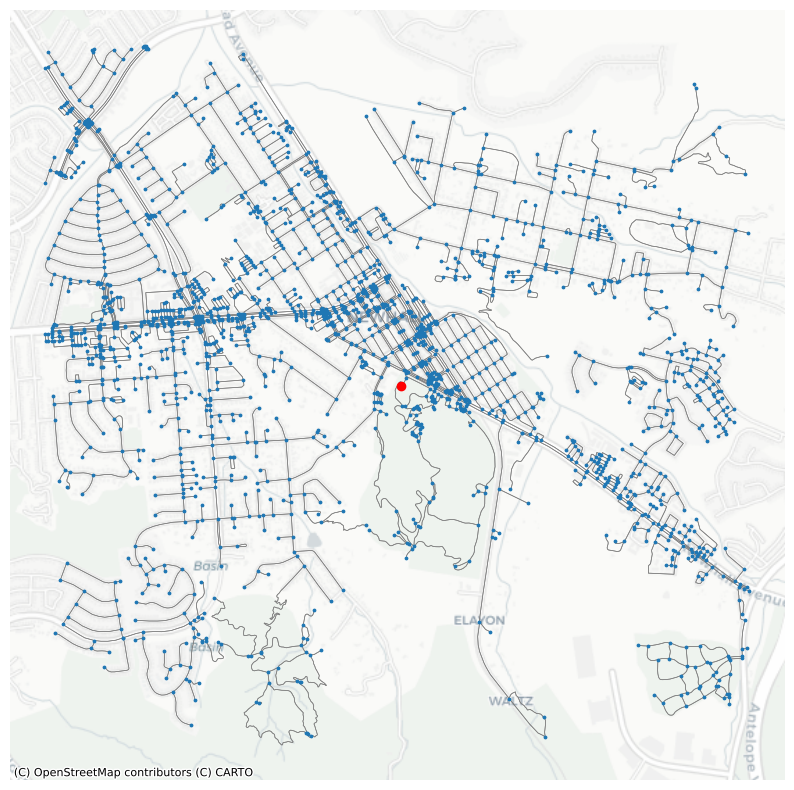

In [9]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
gdf_edges.plot(ax=ax,
               linewidth=0.5, # don't do more than 1
               edgecolor='gray', # line color
               zorder=10) #3D position (layers)

# add all nodes to ax
gdf_nodes.plot(ax=ax, 
               markersize=3, 
               zorder=20) #this is higher so goes over the lines

# add the center node in red also to ax
gdf_nodes.loc[[center_node]].plot(ax=ax,
                                  color='r', 
                                  zorder=30) # top-most layers

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,zoom=14)

# post note: that worked out well because the centroid is focused on the parking lot entrance to the park, where Walkrs would access it. 

In [10]:
gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

In [11]:
gdf_edges[['osmid','name','highway','length','walk_time']].sample(15)

osmid             name  \
u          v           key                                            
9349877302 5268113966  0                 555452803   Cross Motorway   
123205386  123205389   0                 608795419   Newhall Avenue   
7825111968 122675386   0     [838835402, 13384671]      Via Boscana   
122898557  11294862171 0                1218947051  Railroad Avenue   
3689373861 3689373849  0                 364914415              NaN   
122492380  330001711   0                  13339405    Trumpet Drive   
3689373831 3689373834  0                 364914418              NaN   
4282064426 122401985   0                  13257052              NaN   
123416715  123449624   0                  13418099    Heritage Lane   
3573042249 8218433630  0    [636634452, 636634438]     Lyons Avenue   
5339900942 5339900937  0                 553147677    Highland Loop   
4354596223 4354596171  0                 437666883              NaN   
7834229815 122496848   0                  13390181    Valle del Oro   
6788029055 6788029043  0                 723760532              NaN   
123248653  122733976   0                  13435227  Oakcreek Avenue   

                                        highway   length  walk_time  
u          v           key                                           
9349877302 5268113966  0                  track  138.926   1.852347  
123205386  123205389   0            residential   55.550   0.740667  
7825111968 122675386   0    [path, residential]  266.625   3.555000  
122898557  11294862171 0                primary   22.517   0.300227  
3689373861 3689373849  0                service   43.146   0.575280  
122492380  330001711   0            residential   89.426   1.192347  
3689373831 3689373834  0                service   17.393   0.231907  
4282064426 122401985   0                service  109.989   1.466520  
123416715  123449624   0            residential  101.301   1.350680  
3573042249 8218433630  0              secondary   42.449   0.565987  
5339900942 5339900937  0                   path   60.612   0.808160  
4354596223 4354596171  0                service   98.721   1.316280  
7834229815 122496848   0                service   28.808   0.384107  
6788029055 6788029043  0                service   88.325   1.177667  
123248653  122733976   0            residential  149.567   1.994227

## I get it now.
It took me a while to understand this but I get it. The Walk_time is a function of the length of the edges, not the time to get to the centroid. I have to say it again so I don't forget.

In [12]:
cmap = 'RdYlGn_r'

In [13]:
# assign a color hex code for each trip time isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap=cmap, 
                                start=0, 
                                return_hex=True)
print(trip_times)
print(iso_colors)

[5, 10, 15, 20]
['#006837', '#b7e075', '#fdbf6f', '#a50026']


In [14]:
iso_colors.reverse()
iso_colors

['#a50026', '#fdbf6f', '#b7e075', '#006837']

In [15]:
time_color = list(zip(trip_times, iso_colors))
time_color

[(5, '#a50026'), (10, '#fdbf6f'), (15, '#b7e075'), (20, '#006837')]

In [16]:
for time,color in list(time_color):
    print('The color for a '+str(time)+' minute Walk is ' + color) # change this a tiny bit for grammer

The color for a 5 minute Walk is #a50026
The color for a 10 minute Walk is #fdbf6f
The color for a 15 minute Walk is #b7e075
The color for a 20 minute Walk is #006837


In [17]:
time_color.reverse()
time_color

[(20, '#006837'), (15, '#b7e075'), (10, '#fdbf6f'), (5, '#a50026')]

In [18]:
# loop through each trip time and associated color
for time, color in list(time_color):

    # for each trip time, create an egograph of nodes that fall within that distance
    subgraph = nx.ego_graph(G, center_node, radius=time,distance='time') #centernode is the park, defined earlier 

    print('There are ' + str(len(subgraph.nodes())) + ' nodes within ' + str(time) + ' a minute Walk ' + color)
    
    # for each of those nodes, update the gdf_nodes dataframe and assign it with its associated distance color
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = time
        gdf_nodes.loc[node,'color'] = color

There are 562 nodes within 20 a minute Walk #006837
There are 257 nodes within 15 a minute Walk #b7e075
There are 69 nodes within 10 a minute Walk #fdbf6f
There are 12 nodes within 5 a minute Walk #a50026


In [19]:
gdf_nodes.sample(10)

y             x  street_count         lon        lat  \
osmid                                                                         
6788029055  4.079626e+06 -1.319647e+07             3 -118.545926  34.377659   
122938703   4.080998e+06 -1.319432e+07             3 -118.526579  34.387829   
8311054321  4.078854e+06 -1.319291e+07             3 -118.513908  34.371936   
8413321684  4.080992e+06 -1.319513e+07             4 -118.533847  34.387788   
7925405274  4.079646e+06 -1.319663e+07             3 -118.547386  34.377809   
3695540275  4.081140e+06 -1.319549e+07             3 -118.537069  34.388884   
1977032784  4.079885e+06 -1.319614e+07             3 -118.542940  34.379583   
7888729374  4.079975e+06 -1.319472e+07             3 -118.530215  34.380245   
4666275879  4.079762e+06 -1.319690e+07             3 -118.549810  34.378672   
8413321683  4.080900e+06 -1.319507e+07             4 -118.533322  34.387104   

             highway                           geometry  time    color  
osmid                                                                   
6788029055       NaN  POINT (-13196472.118 4079625.795)   NaN      nan  
122938703        NaN  POINT (-13194318.475 4080997.629)   NaN      nan  
8311054321       NaN  POINT (-13192907.835 4078853.954)   NaN      nan  
8413321684  crossing  POINT (-13195127.523 4080992.112)   NaN      nan  
7925405274       NaN  POINT (-13196634.600 4079646.013)   NaN      nan  
3695540275       NaN  POINT (-13195486.206 4081139.917)   NaN      nan  
1977032784       NaN  POINT (-13196139.696 4079885.330)   NaN      nan  
7888729374       NaN  POINT (-13194723.222 4079974.636)  20.0  #006837  
4666275879       NaN  POINT (-13196904.461 4079762.400)   NaN      nan  
8413321683  crossing  POINT (-13195069.103 4080899.858)   NaN      nan

In [20]:
import numpy as np
gdf_nodes['color'] = gdf_nodes['color'].replace('nan', np.nan)
gdf_nodes = gdf_nodes.dropna(subset=['color'])
gdf_nodes

y             x  street_count         lon        lat  \
osmid                                                                          
4282064422   4.079466e+06 -1.319385e+07             4 -118.522338  34.376470   
122898543    4.079545e+06 -1.319397e+07             4 -118.523431  34.377063   
2223516367   4.079878e+06 -1.319426e+07             3 -118.526093  34.379529   
122401978    4.079626e+06 -1.319409e+07             4 -118.524507  34.377658   
123416906    4.079703e+06 -1.319421e+07             3 -118.525618  34.378231   
...                   ...           ...           ...         ...        ...   
11294971972  4.079851e+06 -1.319439e+07             3 -118.527244  34.379327   
11294971974  4.079864e+06 -1.319437e+07             3 -118.527053  34.379428   
11415633650  4.079958e+06 -1.319548e+07             1 -118.536993  34.380125   
11415647771  4.079951e+06 -1.319560e+07             3 -118.538072  34.380067   
11415633666  4.079913e+06 -1.319561e+07             4 -118.538158  34.379789   

            highway                           geometry  time    color  
osmid                                                                  
4282064422      NaN  POINT (-13193846.258 4079465.507)  20.0  #006837  
122898543       NaN  POINT (-13193967.941 4079545.408)  20.0  #006837  
2223516367      NaN  POINT (-13194264.318 4079878.101)  20.0  #006837  
122401978       NaN  POINT (-13194087.710 4079625.660)  20.0  #006837  
123416906       NaN  POINT (-13194211.464 4079703.026)  20.0  #006837  
...             ...                                ...   ...      ...  
11294971972     NaN  POINT (-13194392.436 4079850.774)  20.0  #006837  
11294971974     NaN  POINT (-13194371.163 4079864.410)  20.0  #006837  
11415633650     NaN  POINT (-13195477.723 4079958.409)  20.0  #006837  
11415647771     NaN  POINT (-13195597.759 4079950.586)  20.0  #006837  
11415633666     NaN  POINT (-13195607.399 4079913.102)  20.0  #006837  

[562 rows x 9 columns]

In [21]:
isochrones = gdf_nodes.dissolve(by = "time")
isochrones
# make the polygons by the time intervals

geometry             y  \
time                                                                    
5.0   MULTIPOINT ((-13194509.466 4079472.857), (-131...  4.079252e+06   
10.0  MULTIPOINT ((-13194761.082 4079695.136), (-131...  4.079695e+06   
15.0  MULTIPOINT ((-13195473.716 4079932.863), (-131...  4.079928e+06   
20.0  MULTIPOINT ((-13195639.760 4079733.509), (-131...  4.079466e+06   

                 x  street_count         lon        lat         highway  \
time                                                                      
5.0  -1.319445e+07             3 -118.527721  34.374887            None   
10.0 -1.319476e+07             4 -118.530556  34.378173        crossing   
15.0 -1.319543e+07             3 -118.536534  34.379898        crossing   
20.0 -1.319385e+07             4 -118.522338  34.376470  turning_circle   

        color  
time           
5.0   #a50026  
10.0  #fdbf6f  
15.0  #b7e075  
20.0  #006837

In [22]:
isochrones = isochrones.convex_hull.reset_index(name='geometry')
isochrones
# make the polygon outta the nodes

time                                           geometry
0   5.0  POLYGON ((-13194398.125 4079189.756, -13194470...
1  10.0  POLYGON ((-13194280.426 4078689.482, -13194670...
2  15.0  POLYGON ((-13194132.494 4078211.376, -13194430...
3  20.0  POLYGON ((-13193759.006 4077300.600, -13195249...

In [23]:
isochrones.sort_values(by='time', ascending=False,inplace=True)
isochrones.rename(columns={'time': 'Walk Time (min)'}, inplace=True)
isochrones

Walk Time (min)                                           geometry
3             20.0  POLYGON ((-13193759.006 4077300.600, -13195249...
2             15.0  POLYGON ((-13194132.494 4078211.376, -13194430...
1             10.0  POLYGON ((-13194280.426 4078689.482, -13194670...
0              5.0  POLYGON ((-13194398.125 4079189.756, -13194470...

# Add in other datasets

In [24]:
import pandas as pd 
import geopandas as gpd

In [25]:
Income = pd.read_excel(
    'Data/Income-Data.xlsx',
    dtype=
    {
        'GEO_ID':str,
    }
)
Income = Income.drop([0])
Income.info

<bound method DataFrame.info of       Geometry       GEO_ID  Less_10k  10k_to_14999  15k_to_19999  20k_24999  \
1     1400000U  06037101110        54           126            49         33   
2     1400000U  06037101122        88             0             7         42   
3     1400000U  06037101220        78            82            28        102   
4     1400000U  06037101221        76           107           118        148   
5     1400000U  06037101222       161           167            34         41   
...        ...          ...       ...           ...           ...        ...   
2494  1400000U  06037980038         0             0             0          0   
2495  1400000U  06037980039         0             0             0          0   
2496  1400000U  06037990100         0             0             0          0   
2497  1400000U  06037990200         0             0             0          0   
2498  1400000U  06037990300         0             0             0          0   

      2

In [26]:
Tracts = gpd.read_file('Data/tl_2021_06_tract.zip')

Tracts1 = Tracts[['GEOID','geometry']]
Tracts1.columns = ['GEO_ID',
'geometry']
Tracts1.head()

GEO_ID                                           geometry
0  06085504321  POLYGON ((-121.87556 37.39924, -121.87535 37.3...
1  06085504410  POLYGON ((-121.88886 37.40758, -121.88576 37.4...
2  06085507003  POLYGON ((-122.02489 37.21683, -122.02459 37.2...
3  06085507004  POLYGON ((-121.99304 37.22562, -121.99249 37.2...
4  06085502204  POLYGON ((-121.93167 37.29803, -121.92801 37.3...

In [27]:
District5 = pd.read_excel('Data/District5.xlsx',
    dtype =
    {
        'CT20':str,
    }
)
District5['GEO_ID'] = '06' + '037' + District5['CT20']
District5.head()

OBJECTID_12  Join_Count  TARGET_FID    CT20    LABEL               NAME  \
0            1           1           1  101110  1011.10  5TH SUP. DISTRICT   
1            2           1           2  101122  1011.22  5TH SUP. DISTRICT   
2            3           1           3  101220  1012.20  5TH SUP. DISTRICT   
3            4           1           4  101221  1012.21  5TH SUP. DISTRICT   
4            5           1           5  101222  1012.22  5TH SUP. DISTRICT   

                       SUP_NAME  DIST_SUP CITYNAME_ALF NAME_1  \
0  5TH DISTRICT: KATHRYN BARGER         5  LOS ANGELES    NaN   
1  5TH DISTRICT: KATHRYN BARGER         5  LOS ANGELES    NaN   
2  5TH DISTRICT: KATHRYN BARGER         5  LOS ANGELES    NaN   
3  5TH DISTRICT: KATHRYN BARGER         5  LOS ANGELES    NaN   
4  5TH DISTRICT: KATHRYN BARGER         5  LOS ANGELES    NaN   

        JURISDICTION  AREA_NUM                          AREA_NAME  \
0  INCORPORATED CITY         3  San Fernando Valley Planning Area   
1  INCORPORATED CITY         3  San Fernando Valley Planning Area   
2  INCORPORATED CITY         3  San Fernando Valley Planning Area   
3  INCORPORATED CITY         3  San Fernando Valley Planning Area   
4  INCORPORATED CITY         3  San Fernando Valley Planning Area   

    Shape__Area  Shape__Length       GEO_ID  
0  1.676519e+06    5565.411341  06037101110  
1  3.881001e+06   11695.304277  06037101122  
2  1.025452e+06    4688.607147  06037101220  
3  5.197057e+05    3378.824327  06037101221  
4  4.350619e+05    3685.233312  06037101222

In [28]:
District5Tracts=Tracts1.merge(District5,on="GEO_ID")
District5Tracts.head()

GEO_ID                                           geometry  \
0  06037311801  POLYGON ((-118.31214 34.16444, -118.31067 34.1...   
1  06037463800  POLYGON ((-118.18604 34.13383, -118.18553 34.1...   
2  06037463900  POLYGON ((-118.16805 34.12392, -118.16778 34.1...   
3  06037464000  POLYGON ((-118.15038 34.13577, -118.14957 34.1...   
4  06037464200  POLYGON ((-118.10850 34.13427, -118.10850 34.1...   

   OBJECTID_12  Join_Count  TARGET_FID    CT20    LABEL               NAME  \
0         1171           1        1171  311801  3118.01  5TH SUP. DISTRICT   
1         1500           2        1500  463800  4638.00  5TH SUP. DISTRICT   
2         1501           2        1501  463900  4639.00  5TH SUP. DISTRICT   
3         1502           1        1502  464000  4640.00  5TH SUP. DISTRICT   
4         1505           2        1505  464200  4642.00  5TH SUP. DISTRICT   

                       SUP_NAME  DIST_SUP CITYNAME_ALF NAME_1  \
0  5TH DISTRICT: KATHRYN BARGER         5      BURBANK    NaN   
1  5TH DISTRICT: KATHRYN BARGER         5     PASADENA    NaN   
2  5TH DISTRICT: KATHRYN BARGER         5     PASADENA    NaN   
3  5TH DISTRICT: KATHRYN BARGER         5     PASADENA    NaN   
4  5TH DISTRICT: KATHRYN BARGER         5   SAN MARINO    NaN   

        JURISDICTION  AREA_NUM                              AREA_NAME  \
0  INCORPORATED CITY         3      San Fernando Valley Planning Area   
1  INCORPORATED CITY         7  West San Gabriel Valley Planning Area   
2  INCORPORATED CITY         7  West San Gabriel Valley Planning Area   
3  INCORPORATED CITY         7  West San Gabriel Valley Planning Area   
4  INCORPORATED CITY         7  West San Gabriel Valley Planning Area   

    Shape__Area  Shape__Length  
0  8.876761e+05    4455.827633  
1  4.195680e+06   11089.630952  
2  2.753484e+06    7117.630267  
3  4.603528e+06    9832.312127  
4  5.062513e+06    9596.189256

In [29]:
District5TractsGEO=District5Tracts.merge(Income,on="GEO_ID")
District5TractsGEO.head()

GEO_ID                                           geometry  \
0  06037311801  POLYGON ((-118.31214 34.16444, -118.31067 34.1...   
1  06037463800  POLYGON ((-118.18604 34.13383, -118.18553 34.1...   
2  06037463900  POLYGON ((-118.16805 34.12392, -118.16778 34.1...   
3  06037464000  POLYGON ((-118.15038 34.13577, -118.14957 34.1...   
4  06037464200  POLYGON ((-118.10850 34.13427, -118.10850 34.1...   

   OBJECTID_12  Join_Count  TARGET_FID    CT20    LABEL               NAME  \
0         1171           1        1171  311801  3118.01  5TH SUP. DISTRICT   
1         1500           2        1500  463800  4638.00  5TH SUP. DISTRICT   
2         1501           2        1501  463900  4639.00  5TH SUP. DISTRICT   
3         1502           1        1502  464000  4640.00  5TH SUP. DISTRICT   
4         1505           2        1505  464200  4642.00  5TH SUP. DISTRICT   

                       SUP_NAME  DIST_SUP  ... 35k_39999 40k_to_44999  \
0  5TH DISTRICT: KATHRYN BARGER         5  ...        77           95   
1  5TH DISTRICT: KATHRYN BARGER         5  ...        24           12   
2  5TH DISTRICT: KATHRYN BARGER         5  ...        43           18   
3  5TH DISTRICT: KATHRYN BARGER         5  ...        10           10   
4  5TH DISTRICT: KATHRYN BARGER         5  ...        53           56   

  45k_to_49999  50k_to_59999 60k_to_74999  75k_to_99999  100k_to_124999  \
0           77            96           94           124             129   
1           10            34           48           125              86   
2            0            52          118           144             208   
3           25           120          300           198             221   
4           41            65           90           262             100   

  125k_to_149999  150k_to_199999  200k_plus  
0            108              86         47  
1             71             271        650  
2            139             166        362  
3            259             303        647  
4            116             214        754  

[5 rows x 34 columns]

In [30]:
VulnerableCar = pd.read_excel('Data/Transport.xlsx',
 dtype =
    {
        'TRACT':str,
    }
)
VulnerableCar['GEO_ID'] = '06' + '037' + VulnerableCar['TRACT']
VulnerableCar.head()

TRACT  D2_Transp    atmbl_p       GEO_ID
0  101110          2  53.753368  06037101110
1  101122          1  98.986270  06037101122
2  101210          1  28.538432  06037101210
3  101220          2  16.745798  06037101220
4  101300          2  59.707430  06037101300

In [31]:
District5VulnerableCar=District5TractsGEO.merge(VulnerableCar,on="GEO_ID")
District5VulnerableCar.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   GEO_ID          341 non-null    object  
 1   geometry        341 non-null    geometry
 2   OBJECTID_12     341 non-null    int64   
 3   Join_Count      341 non-null    int64   
 4   TARGET_FID      341 non-null    int64   
 5   CT20            341 non-null    object  
 6   LABEL           341 non-null    float64 
 7   NAME            341 non-null    object  
 8   SUP_NAME        341 non-null    object  
 9   DIST_SUP        341 non-null    int64   
 10  CITYNAME_ALF    294 non-null    object  
 11  NAME_1          54 non-null     object  
 12  JURISDICTION    341 non-null    object  
 13  AREA_NUM        341 non-null    int64   
 14  AREA_NAME       341 non-null    object  
 15  Shape__Area     341 non-null    float64 
 16  Shape__Length   341 non-null    float64 
 17  Geometry

In [32]:
m = folium.Map(location=latlon,zoom_start=13, tiles='Cartodb Positron')

# Map it based on D2_Transp
folium.Choropleth(
    geo_data=District5VulnerableCar,
    data=District5VulnerableCar,
    key_on='feature.properties.GEO_ID',
    columns=['GEO_ID','D2_Transp'],
    fill_color='YlOrRd',
    line_weight=0.1, 
    fill_opacity=0.7,
    line_opacity=0.2).add_to(m)  

#Add popups
popup = folium.GeoJsonPopup(
    fields=['D2_Transp','CITYNAME_ALF', 'GEO_ID', 'NAME',],
    aliases=['Number of Transportation Barriers:','City:', 'Census Tract:', 'District:',],
    localize=True,
    sticky=False,
    labels=True,
    style="border:none;", #
)

folium.GeoJson(
    District5VulnerableCar,
    popup=popup,
).add_to(m)

isochrones.explore(m=m,column='Walk Time (min)',color='iso_colors',cmap=cmap,opacity=0.4,categorical=True)

gdf_nodes.explore(m=m,column='time')

title_html = '<h3 align="center" style="font-size:20px"><b>Transportation Barriers overlayed with a 20-minute walking radius around William S. Hart Regional Park in District 5</b></h3>'
m.get_root().html.add_child(folium.Element(title_html))

m

In [33]:
m.save('WilliamHartTransp.html')